# Replicating Laurenti et al.'s autoregressive forecast of p4581 with an LTSM

## Intro & Context

Laurenti uses the segment of the experiment where normal stress = 8 MPa (see p53 of the supplementary material). Note that this is different to the segment provided in Adriano's data loader, which is at normal stress = 2 MPa. For more analysis on how the data varies with normal stress, see TRR26 002.

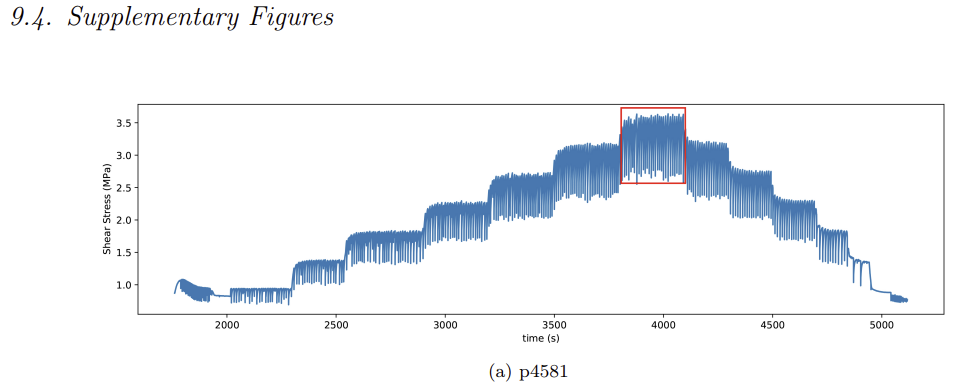

This segment is assumed (high confidence as charts match) to be between 3800 and 4100 seconds, based on the following extract p54 of the supplementary material.

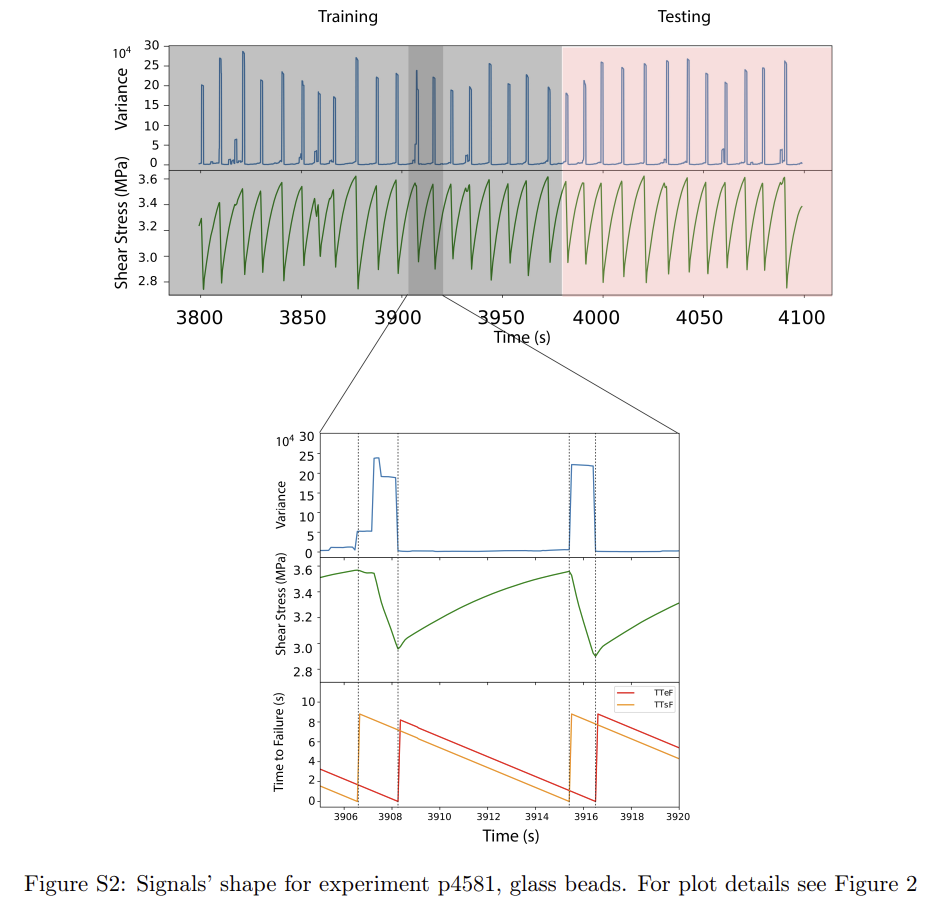

Note that this may not be a good choice as the experiment is transitioning out of 8 MPa normal stress at the beginning and end of this time segment (see extract from analysis in TRR 002). But we'll use it for now.

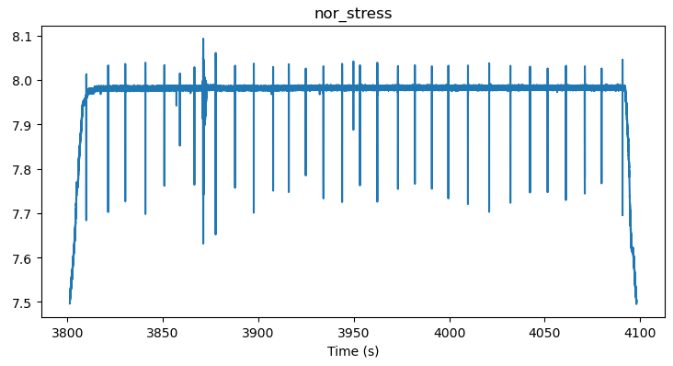

## Imports and data loading

In [6]:
# Set Directories

# Set to True if running on JASMIN, False if on local machine

jasmin = False
jasmin_user_name = "trr26"

if jasmin:
    MAIN_DIR = f"/gws/nopw/j04/ai4er/users/{jasmin_user_name}/earthquake-predictability"
    DATA_DIR = f"{MAIN_DIR}/data/gtc_quakes_data"

else:   # update directory names to match your local machine
    MAIN_DIR = f"/home/tom-ratsakatika/VSCode/earthquake-predictability"
    DATA_DIR = f"{MAIN_DIR}/data"

p4581_FILE_PATH = f"{DATA_DIR}/labquakes/Marone/p4581/p4581.txt"


# Imports

import os
import random
import sys
from math import sqrt

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import torch
import torch.nn as nn
from IPython.display import display
from scipy.io import loadmat
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm

sys.path.append(MAIN_DIR)
import utils

In [7]:
# Check CUDA Availability

if torch.cuda.is_available():
    dev = "cuda"
    map_location = None
    print(f"Total number of GPUs available: {torch.cuda.device_count()}")
    !nvidia-smi
else:
    dev = "cpu"
    map_location = "cpu"
    print("No GPU available.")
device = torch.device(dev)

Total number of GPUs available: 1
Wed Jan 24 10:52:40 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.146.02             Driver Version: 535.146.02   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    Off | 00000000:01:00.0 Off |                  N/A |
| N/A   57C    P0              19W /  35W |   1364MiB /  4096MiB |      5%      Default |
|                                         |                      |                  N/A |
+---------------------------------

,time,lp_disp,shr_stress,nor_disp,nor_stress,sync,samp_freq
0,1.0,0.0,0.0,-0.0,1.000000e-18,3.29854,1
1,2.0,0.0,0.0,-0.0,1.000000e-18,3.29853,1
2,3.0,0.0,0.0,-0.0,1.000000e-18,3.29853,1
3,4.0,0.0,0.0,-0.0,1.000000e-18,3.29854,1
4,5.0,0.0,0.0,-0.0,1.000000e-18,3.29855,1


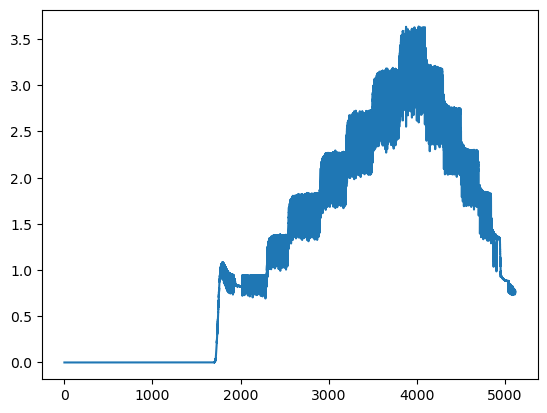

In [8]:
with open(p4581_FILE_PATH, "r") as file:
    df = pd.read_csv(file, delim_whitespace=True, skiprows=4)

df.columns = [
    "id",
    "lp_disp",
    "shr_stress",
    "nor_disp",
    "nor_stress",
    "time",
    "sync",
    "samp_freq",
]

df = df.drop(["id"], axis=1)
df = df[["time"] + [col for col in df.columns if col != "time"]]

plt.plot(df["time"], df["shr_stress"])

df.head()

In [9]:
## Define a de-trend function - we won't use this to start with


def detrend_first_order_poly(x, y):
    p = np.polyfit(x, y, deg=1)
    y_det = y - (p[0] * x + p[1])
    return y_det

## Define the time segment and visualise the data

In [10]:
start_time = 3800
end_time = 4099.99  # adjusted slightly so that the size of the dataframe can be divided exactly by 100. this is necessary due to a oddity of Laurenti's createsubwindow function

# time_range = (df["time"] >= start_time) & (df["time"] <= end_time)#
# time = df.loc[time_range, "time"]
# shear_stress = df.loc[time_range, "shr_stress"]
# y_det = detrend_first_order_poly(x, y)

filtered_data = df[(df["time"] >= start_time) & (df["time"] <= end_time)]
df = (
    filtered_data[["shr_stress", "time"]]
    .copy()
    .astype({"shr_stress": "float32", "time": "float32"})
)
df = df.reset_index(drop=True)
df.head()

,shr_stress,time
0,3.28402,3800.0
1,3.28402,3800.0
2,3.28385,3800.0
3,3.28390,3800.0
4,3.28384,3800.0


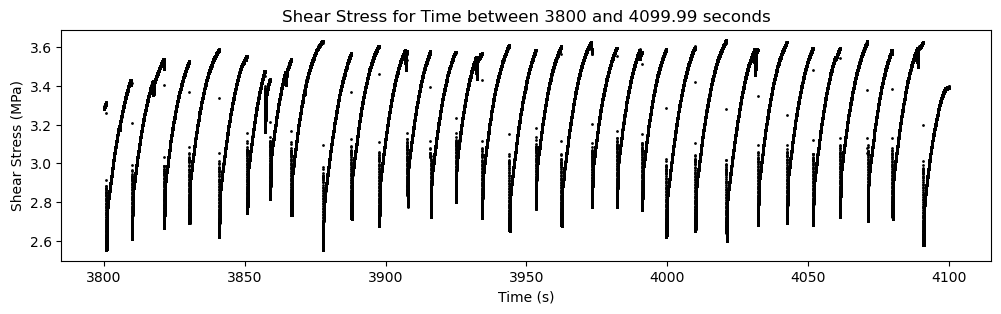

In [11]:
plt.figure(figsize=(12, 3))
plt.plot(df["time"], df["shr_stress"], ".k", markersize=2)
plt.xlabel("Time (s)")
plt.ylabel("Shear Stress (MPa)")
plt.title(f"Shear Stress for Time between {start_time} and {end_time} seconds")
plt.show()

Note the near exact match with the chart above from supplementary material. The minimum value of some of the toughs appear lower in our graph, although this could be due to rendering differences. **To do: check minimum points match.**

## Data pre-processing

The first thing Laurenti et al. does is min-max scaling (sklearn pre-processing) and then data smoothing/downsampling using her own function.

**Comment: predicting smoothed data is presumably an easier task - do we want to do the same?**

First we do Mix-Max Scaling...

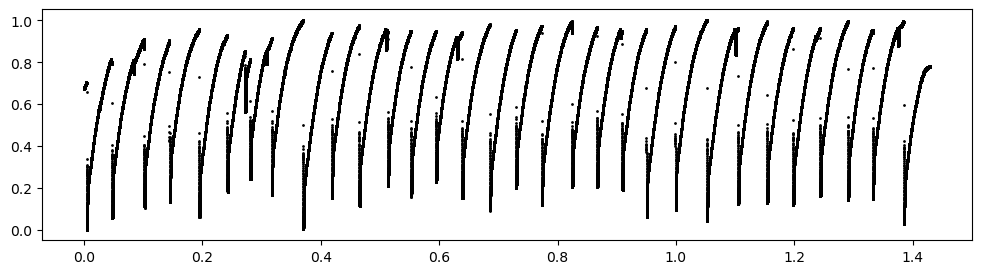

In [12]:
### Min-Max Scaling

min_max_scaler = preprocessing.MinMaxScaler()
x = df[
    : int(len(df) * 0.7)
].values  # Not sure why min-max scaling is applied to the time column as well as shear stress?
min_max_scaler.fit(x)  # Fits the min-max scaler to the training set only...
x_scaled = min_max_scaler.transform(
    df.values
)  # ...but applies the scaling to both test and train (so some test/train values could be <> 0-1
df_scaled = pd.DataFrame(x_scaled)

plt.figure(figsize=(12, 3))
plt.plot(df_scaled[1], df_scaled[0], ".k", markersize=2)
plt.show()

Then we define Laurenti's smoothing function:

- First it calculates a trimmed moving average over 1000 points, excluding outliers in the calculation of the mean.
- Then it downsamples, taking one point every n steps. But it still keeps all the data, it just creates n columns, each staggered by one time step.
- Note that this function only works properly if the length of the input can be divided by n without a remainder. Recommend we correct this.

**Comment: changing the plot so that we see the individual points (rather than an extrapolated line which is the default) gives a better intuition about how much data we lose by lowering the resolution. Specifically, it is very difficult to see TTsF and TTeF.**

In [13]:
# Laurenti's create sub-window function.


def CreateSubwindows(df, n=100):
    """Creates running windows to interpolate the DataFrame.
    It takes 1 point every n to low[er] the resolution.

    Args:
    ----------
    df : DataFrame
        Input DataFrame
    n : int (default=100)
        Number of points to take in lowering the resolution.

    Returns:
    ----------
    df : resulting DataFrame
    """

    # Laurenti: running windows to interpolate the df
    # Tom: this calculates a rolling average (mean) over 1000 points, but excludes to highest and lowest 5% of points when doing so
    df = df.rolling(1000).apply(
        lambda w: scipy.stats.trim_mean(w, 0.05)
    )  # mean without outliers (5 and 95 percentile)
    df = df[
        1000 : (len(df))
    ]  # Tom: removes the first 1000 points as only partial rolling average will have been calculated here
    df = df.reset_index()
    df = df.drop(["index"], axis=1)

    # Laurenti: now we take 1 point every n to low the resolution
    # Tom: This
    subwindows = [
        list(i)
        for i in zip(
            *[
                df.values.reshape(-1)[i : i + n]
                for i in range(0, len(df.values.reshape(-1)), n)
            ]
        )
    ]
    df = pd.DataFrame(subwindows)
    df = df.T
    df = df.apply(np.float32)
    print("A plot of example:")
    plt.figure(figsize=(12, 3))
    plt.plot(df[40], "k", markersize=2)
    plt.show()

    return df

A plot of example:


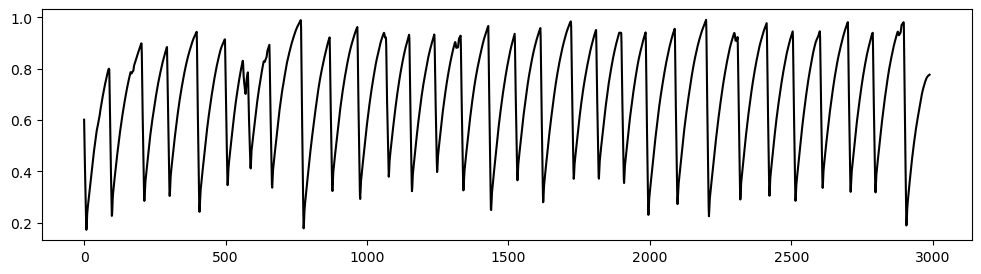

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.631091,0.630345,0.629598,0.628852,0.628106,0.627360,0.626614,0.625868,0.625122,0.624376,...,0.564862,0.564142,0.563422,0.562702,0.561983,0.561265,0.560546,0.559829,0.559112,0.558396
1,0.557680,0.556964,0.556249,0.555535,0.554820,0.554107,0.553395,0.552682,0.551971,0.551260,...,0.496814,0.496188,0.495563,0.494939,0.494317,0.493696,0.493075,0.492456,0.491838,0.491222
2,0.490607,0.489992,0.489380,0.488768,0.488158,0.487549,0.486940,0.486334,0.485728,0.485124,...,0.439533,0.438995,0.438458,0.437920,0.437382,0.436845,0.436308,0.435771,0.435233,0.434696
3,0.434159,0.433621,0.433085,0.432548,0.432011,0.431473,0.430937,0.430400,0.429863,0.429326,...,0.386196,0.385668,0.385141,0.384614,0.384086,0.383559,0.383032,0.382504,0.381977,0.381450
4,0.380922,0.380394,0.379867,0.379339,0.378812,0.378284,0.377757,0.377229,0.376702,0.376174,...,0.333847,0.333331,0.332815,0.332299,0.331783,0.331267,0.330750,0.330234,0.329717,0.329201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2985,0.773161,0.773172,0.773184,0.773195,0.773207,0.773218,0.773230,0.773241,0.773252,0.773264,...,0.774039,0.774050,0.774061,0.774072,0.774083,0.774094,0.774105,0.774116,0.774127,0.774138
2986,0.774149,0.774160,0.774171,0.774181,0.774192,0.774203,0.774213,0.774224,0.774234,0.774245,...,0.774940,0.774948,0.774955,0.774962,0.774969,0.774976,0.774983,0.774989,0.774996,0.775002
2987,0.775009,0.775015,0.775022,0.775029,0.775035,0.775041,0.775048,0.775055,0.775061,0.775068,...,0.775675,0.775683,0.775691,0.775699,0.775706,0.775715,0.775722,0.775730,0.775738,0.775745
2988,0.775752,0.775760,0.775768,0.775775,0.775782,0.775790,0.775797,0.775804,0.775812,0.775819,...,0.776403,0.776410,0.776418,0.776425,0.776433,0.776440,0.776448,0.776455,0.776463,0.776470


In [14]:
df_smoothed = CreateSubwindows(df_scaled[0])
df_smoothed

## Initialise the functions and classes in Laurenti's 'utils.py' file

Just copying and pasting for now.

In [15]:
def train_val_test_split(
    df,
    train_percentage,
    val_percentage,
    test_percentage,
    window_shift,
    batch_size,
    steps_in=200,
    steps_out=100,
):
    """Splits the input DataFrame in train, validation and test.

    Args:
    ----------
    df : DataFrame
          Input DataFrame
    train_percentage : float 0<=train_percentage<=1 (suggestion=0.7)
          Percentage of df length to use as training data.
    val_percentage : float 0<=val_percentage<=1 (suggestion=0.1)
          Percentage of df length to use as validation data.
    test_percentage : float 0<=test_percentage<=1 (suggestion=0.2)
          Percentage of df length to use as testing data.
          Note: train_percentage+val_percentage+test_percentage must be <1 and should be =1.
    window_shift : int (suggestion=10)
          Shift between one window and the following.
    batch_size : int
          Size of the batch used during the training of the model.
    steps_in : int (default=200)
          Number of points in input for the model, representing the known past.
    steps_out : int (default=100)
          Number of points in output from the model, representing the future to be forecasted.

    Returns:
    ----------
    tr_dl : torch.utils.data.DataLoader
          Resulting training set
    val_dl : torch.data.DataLoader
          Resulting validation set
    test_dl : torch.utils.data.DataLoader
          Resulting testing set

    """
    train_size = int(len(df) * train_percentage)
    dataset_train = df[0:train_size]
    training_set = dataset_train.iloc[:, 0 : dataset_train.shape[1]].values

    val_size = int(len(df) * val_percentage)
    dataset_val = df[
        train_size - steps_out : train_size + val_size + steps_out
    ]
    val_set = dataset_val.iloc[:, 0 : dataset_val.shape[1]].values

    test_size = int(len(df) * test_percentage)
    dataset_test = df[
        train_size + val_size - steps_out : train_size + val_size + test_size
    ]
    test_set = dataset_test.iloc[:, 0 : dataset_test.shape[1]].values

    print(
        "training_set.shape: ",
        training_set.shape,
        " val_set.shape: ",
        val_set.shape,
        " test_set.shape: ",
        test_set.shape,
    )

    df_tr = []
    for j in range(0, training_set.shape[1]):
        for i in range(
            0, training_set.shape[0] - steps_in - steps_out, window_shift
        ):
            df_tr.append(training_set[:, j][i : i + steps_in + steps_out])

    X_train = []
    y_train = []
    label_train = []
    for elem in df_tr:
        X_train.append(
            np.expand_dims(elem[0:steps_in], axis=1)
        )  # this is 0 to 199 inclusive - 200 elements
        y_train.append(
            np.expand_dims(elem[steps_in:-1], axis=1)
        )  # this is 200 to 298 inclusive (99 elements), excluding the last element - why?
        label_train.append(
            np.expand_dims(elem[steps_in:], axis=1)
        )  # what does label do? it's something to do with teacher forcing
    X_train, y_train, label_train = (
        np.array(X_train),
        np.array(y_train),
        np.array(label_train),
    )
    print(
        "X_train.shape: ",
        X_train.shape,
        " y_train.shape: ",
        y_train.shape,
        " label_train.shape: ",
        label_train.shape,
    )

    df_val = []
    for j in range(0, val_set.shape[1]):
        for i in range(
            0, val_set.shape[0] - steps_in - steps_out, window_shift
        ):
            df_val.append(val_set[:, j][i : i + steps_in + steps_out])

    X_val = []
    y_val = []
    label_val = []
    for elem in df_val:
        X_val.append(np.expand_dims(elem[0:steps_in], axis=1))
        y_val.append(np.expand_dims(elem[steps_in:-1], axis=1))
        label_val.append(np.expand_dims(elem[steps_in:], axis=1))
    X_val, y_val, label_val = (
        np.array(X_val),
        np.array(y_val),
        np.array(label_val),
    )
    print(
        "X_val.shape: ",
        X_val.shape,
        " y_val.shape: ",
        y_val.shape,
        " label_val.shape: ",
        label_val.shape,
    )

    df_test = []
    for j in range(0, test_set.shape[1]):
        for i in range(
            0, test_set.shape[0] - steps_in - steps_out, window_shift
        ):
            df_test.append(test_set[:, j][i : i + steps_in + steps_out])

    X_test = []
    y_test = []
    label_test = []
    for elem in df_test:
        X_test.append(np.expand_dims(elem[0:steps_in], axis=1))
        y_test.append(np.expand_dims(elem[steps_in:-1], axis=1))
        label_test.append(np.expand_dims(elem[steps_in:], axis=1))
    X_test, y_test, label_test = (
        np.array(X_test),
        np.array(y_test),
        np.array(label_test),
    )
    print(
        "X_test.shape: ",
        X_test.shape,
        " y_test.shape: ",
        y_test.shape,
        " label_test.shape: ",
        label_test.shape,
    )

    src_train, trg_train, lab_train = (
        torch.from_numpy(X_train),
        torch.from_numpy(y_train),
        torch.from_numpy(label_train),
    )
    src_val, trg_val, lab_val = (
        torch.from_numpy(X_val),
        torch.from_numpy(y_val),
        torch.from_numpy(label_val),
    )
    src_test, trg_test, lab_test = (
        torch.from_numpy(X_test),
        torch.from_numpy(y_test),
        torch.from_numpy(label_test),
    )

    train_dataset = TensorDataset(src_train, trg_train, lab_train)
    val_dataset = TensorDataset(src_val, trg_val, lab_val)
    test_dataset = TensorDataset(src_test, trg_test, lab_test)

    tr_dl = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        drop_last=True,
    )
    val_dl = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        drop_last=True,
    )
    test_dl = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        drop_last=True,
    )

    return tr_dl, val_dl, test_dl

In [16]:
def update_lr(optimizer, lr):
    """Updates the learning rate of the model optimizer.

    Args:
    ----------
    optimizer : torch.optim
        Model optimizer.
    lr : float
        New learning rate to be used.

    """
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [17]:
class RMSELoss(nn.Module):
    """Loss function for the training of the model."""

    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps

    def forward(self, yhat, y):
        loss = torch.sqrt(self.mse(yhat, y) + self.eps)
        return loss

In [18]:
class LSTM(nn.Module):
    """Long-Short Term Memory Network"""

    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTM, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers, batch_first=True
        )
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(
        self,
        batch_init,
        batch_next,
        batch_size,
        steps_in,
        steps_out,
        tf_prob=1,
    ):

        h_t = torch.zeros(
            self.num_layers, batch_init.size(0), self.hidden_size
        ).to(dev)
        c_t = torch.zeros(
            self.num_layers, batch_init.size(0), self.hidden_size
        ).to(dev)
        hidden = (h_t, c_t)

        pred_out = []

        # observed data
        for idx in range(batch_init.size(1)):
            out_lstm, hidden = self.lstm(
                batch_init[:, idx, :].unsqueeze(1), hidden
            )
            output = self.linear(out_lstm)

        pred_out.append(output)

        # data to predict
        for idx in range(batch_next.size(1)):

            if random.random() < tf_prob:
                inp = batch_next[:, idx, :].unsqueeze(1)
            else:
                inp = output

            out_lstm, hidden = self.lstm(inp, hidden)
            output = self.linear(out_lstm)
            pred_out.append(output)

        return torch.cat(pred_out, 1)

In [19]:
class LinearEmbedding(nn.Module):
    def __init__(self, inp_size, d_model):
        super(LinearEmbedding, self).__init__()
        # lut => lookup table
        self.lut = nn.Linear(inp_size, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

In [20]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."

    def __init__(self, d_model, out_size):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, out_size)

    def forward(self, x):
        return self.proj(x)

## Initialise the ML Model

In [21]:
steps_in = 200
steps_out = 100
batch_size = 32
tr_dl, val_dl, test_dl = train_val_test_split(
    df_smoothed,
    train_percentage=0.70,
    val_percentage=0.10,
    test_percentage=0.20,
    window_shift=10,
    batch_size=batch_size,
    steps_in=steps_in,
    steps_out=steps_out,
)

training_set.shape:  (2093, 100)  val_set.shape:  (499, 100)  test_set.shape:  (698, 100)


X_train.shape:  (18000, 200, 1)  y_train.shape:  (18000, 99, 1)  label_train.shape:  (18000, 100, 1)
X_val.shape:  (2000, 200, 1)  y_val.shape:  (2000, 99, 1)  label_val.shape:  (2000, 100, 1)
X_test.shape:  (4000, 200, 1)  y_test.shape:  (4000, 99, 1)  label_test.shape:  (4000, 100, 1)


In [49]:
mdl = "LSTM"  # "TF" or "TF_PRETR" or "LSTM" or "TCN"

loss_function = RMSELoss()
min_loss = np.Inf
num_epochs = 30             # reduced from 30 to 10
loss_history_tr = []
loss_history_val = []
loss_history_te = []
learning_rate = 0.0001       # reduced from 0.0001
init_lr = learning_rate
lr_decay = 0.99

inp_size = 1
out_size = 1
num_layers = 3          # increased from 3 to 4
hidden_size = 300       # reduced from 300
# outputteLSTM=[]
model = LSTM(
    input_size=inp_size,
    hidden_size=hidden_size,
    output_size=out_size,
    num_layers=num_layers,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)
best_model = type(model)(
    input_size=inp_size,
    hidden_size=hidden_size,
    output_size=out_size,
    num_layers=num_layers,
).to(device)

In [50]:
for epoch in range(num_epochs):

    model.train()
    sum_loss_tr = 0

    for idx, batch in tqdm(enumerate(tr_dl), total=len(tr_dl)):
        model.zero_grad()
        label = batch[2].to(device)
        inp = batch[0].to(device)
        target = batch[1].to(device)

        output = model(
            inp.float(),
            target.float(),
            batch_size=batch_size,
            steps_in=steps_in,
            steps_out=steps_out,
            tf_prob=1,
        )
        current_loss = loss_function(output, label)
        current_loss.backward()

        optimizer.step()
        sum_loss_tr += (current_loss.item() ** 2) * batch_size

    curr_tr_loss = np.sqrt(sum_loss_tr / len(tr_dl))
    loss_history_tr.append(curr_tr_loss)

    model.eval()
    with torch.no_grad():
        sum_loss_val = 0

        for idx, batch in tqdm(enumerate(val_dl), total=len(val_dl)):
            label = batch[2].to(device)
            inp = batch[0].to(device)
            target = batch[1].to(device)

            output = model(
                inp.float(),
                target.float(),
                batch_size=batch_size,
                steps_in=steps_in,
                steps_out=steps_out,
                tf_prob=0,
            )
            sum_loss_val += (
                loss_function(output, label).item() ** 2
            ) * batch_size

        curr_val_loss = np.sqrt(sum_loss_val / len(val_dl))
        loss_history_val.append(curr_val_loss)

        if curr_val_loss < min_loss:
            min_loss = curr_val_loss
            del best_model
            best_model = type(model)(
                input_size=inp_size,
                hidden_size=hidden_size,
                output_size=out_size,
                num_layers=num_layers,
            )
            best_model.load_state_dict(model.state_dict())
            torch.save(best_model.state_dict(), "LSTM_bestmodel.pt")
            print("Best Epoch:", epoch + 1)

    model.eval()
    with torch.no_grad():

        sum_loss_te = 0
        for idx, batch in tqdm(enumerate(test_dl), total=len(test_dl)):
            label = batch[2].to(device)
            inp = batch[0].to(device)
            target = batch[1].to(device)
            output = model(
                inp.float(),
                target.float(),
                batch_size=batch_size,
                steps_in=steps_in,
                steps_out=steps_out,
                tf_prob=0,
            )
            sum_loss_te += (
                loss_function(output, label).item() ** 2
            ) * batch_size

        curr_te_loss = np.sqrt(sum_loss_te / len(test_dl))
        loss_history_te.append(curr_te_loss)

    print(
        "Epoch",
        epoch + 1,
        "\tTrain Loss:",
        curr_tr_loss,
        "\tValid Loss:",
        curr_val_loss,
        "\tTest Loss:",
        curr_te_loss,
    )

  2%|▏         | 2/125 [00:00<00:08, 13.82it/s]

Best Epoch: 1


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 1 	Train Loss: 0.8494047031861538 	Valid Loss: 1.2042465306618502 	Test Loss: 1.2146467681736783


  2%|▏         | 2/125 [00:00<00:08, 14.13it/s]

Best Epoch: 2


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 2 	Train Loss: 0.1629109109530188 	Valid Loss: 1.0544055817473814 	Test Loss: 1.0845023742410969


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 3 	Train Loss: 0.14684771876909664 	Valid Loss: 1.330291892533525 	Test Loss: 1.298757824983508


  2%|▏         | 2/125 [00:00<00:09, 13.20it/s]

Best Epoch: 4


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 4 	Train Loss: 0.13876217293495227 	Valid Loss: 0.9272236327798854 	Test Loss: 0.9941323627198841


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 5 	Train Loss: 0.13145162871594662 	Valid Loss: 1.2717714024687345 	Test Loss: 1.2259325787725996


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 6 	Train Loss: 0.12576436771440097 	Valid Loss: 1.0351105314375988 	Test Loss: 1.0299735722537269


  2%|▏         | 2/125 [00:00<00:07, 16.11it/s]

Best Epoch: 7


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 7 	Train Loss: 0.11957911726898822 	Valid Loss: 0.8903623811013147 	Test Loss: 0.9581235981231772


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 8 	Train Loss: 0.11404078741825513 	Valid Loss: 1.358555295893818 	Test Loss: 1.3123093916841577


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 9 	Train Loss: 0.1088351961371492 	Valid Loss: 0.961362045833528 	Test Loss: 1.0282142744779237


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 10 	Train Loss: 0.10236860622057299 	Valid Loss: 1.7951030137010253 	Test Loss: 1.7804227260159982


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 11 	Train Loss: 0.09689519607762899 	Valid Loss: 1.1328382773774068 	Test Loss: 1.1859769496836876


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 12 	Train Loss: 0.08983305742242338 	Valid Loss: 1.233800215325185 	Test Loss: 1.2528581602865432


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 13 	Train Loss: 0.08436165781715968 	Valid Loss: 1.1634395641830628 	Test Loss: 1.1832399301443137


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 14 	Train Loss: 0.0794464356507066 	Valid Loss: 2.2214748835647846 	Test Loss: 2.3820794633535414


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 15 	Train Loss: 0.07395650258793617 	Valid Loss: 2.8665251032529766 	Test Loss: 3.1893722737459766


  0%|          | 0/562 [00:00<?, ?it/s]

Epoch 16 	Train Loss: 0.06896398247481673 	Valid Loss: 2.944771950132681 	Test Loss: 3.4967376017845626


  8%|▊         | 47/562 [00:13<02:28,  3.47it/s]


KeyboardInterrupt: 

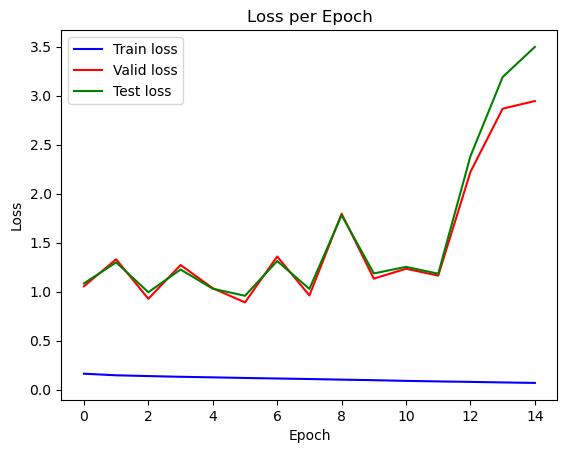

In [51]:
start_epoch = 1

plt.plot(loss_history_tr[start_epoch:], "b-", label="Train loss")
plt.plot(loss_history_val[start_epoch:], "r-", label="Valid loss")
plt.plot(loss_history_te[start_epoch:], "g-", label="Test loss")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [52]:
best_model.to(dev)

inputte = []
labeltte = []
outputte = []
best_model.eval()
with torch.no_grad():
    sum_loss_te = 0
    for idx, batch in tqdm(enumerate(test_dl), total=len(test_dl)):
        label = batch[2].to(device)
        inputte.append(batch[0].to(device))
        inp = batch[0].to(device)
        target = batch[1].to(device)

        if mdl == "TF" or mdl == "TF_PRETR":
            target_c = torch.zeros((target.shape[0], target.shape[1], 1)).to(
                device
            )
            target = torch.cat((target, target_c), -1)
            start_of_seq = (
                torch.Tensor([0, 1])
                .unsqueeze(0)
                .unsqueeze(1)
                .repeat(target.shape[0], 1, 1)
                .to(device)
            )
            src_att = torch.ones((inp.shape[0], 1, inp.shape[1])).to(device)
            dec_inp = start_of_seq
            for i in range(0, steps_out):
                trg_att = (
                    subsequent_mask(dec_inp.shape[1])
                    .repeat(dec_inp.shape[0], 1, 1)
                    .to(device)
                )
                output = best_model(inp, dec_inp, src_att, trg_att)
                last_output = torch.cat(
                    (
                        output[:, -1:, 0].unsqueeze(2),
                        torch.zeros_like(output[:, -1:, 0].unsqueeze(2)),
                    ),
                    2,
                )
                dec_inp = torch.cat((dec_inp, last_output), 1)
            preds = dec_inp[:, 1:, 0].unsqueeze(2)
            outputte.append(preds)
            current_loss = loss_function(preds, label)
        elif mdl == "LSTM":
            output = best_model(
                inp.float(),
                target.float(),
                batch_size=batch_size,
                steps_in=steps_in,
                steps_out=steps_out,
                tf_prob=0,
            )
            outputte.append(output)
            current_loss = loss_function(output, label)
        elif mdl == "TCN":
            output = best_model(
                inp.float(),
                target.float(),
                batch_size=batch_size,
                steps_in=steps_in,
                steps_out=steps_out,
                tf_prob=0,
            )
            outputte.append(output)
            current_loss = loss_function(output, label)
        else:
            print("Experiment not valid. Chose TF or LSTM or TCN")

        labeltte.append(label)
        sum_loss_te += (current_loss.item() ** 2) * batch_size
    curr_te_loss = np.sqrt(sum_loss_te / len(test_dl))
    loss_history_te.append(curr_te_loss)
    print("curr_te_loss: ", curr_te_loss)

100%|██████████| 125/125 [00:08<00:00, 14.08it/s]

curr_te_loss:  0.9581235981231772


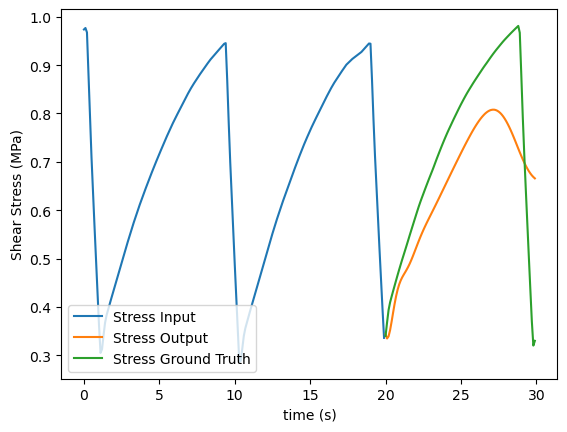

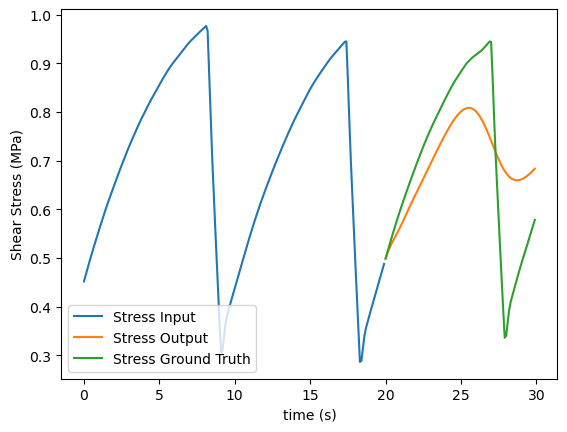

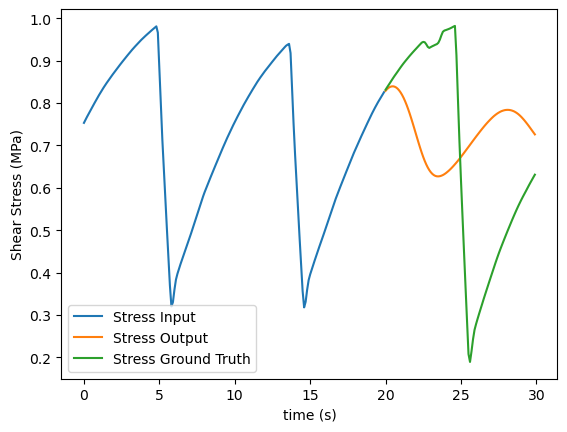

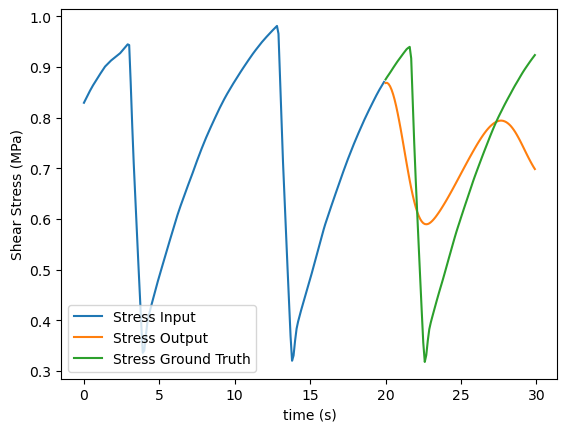

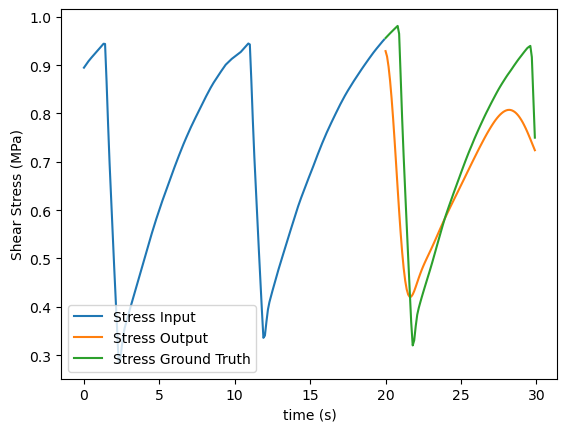

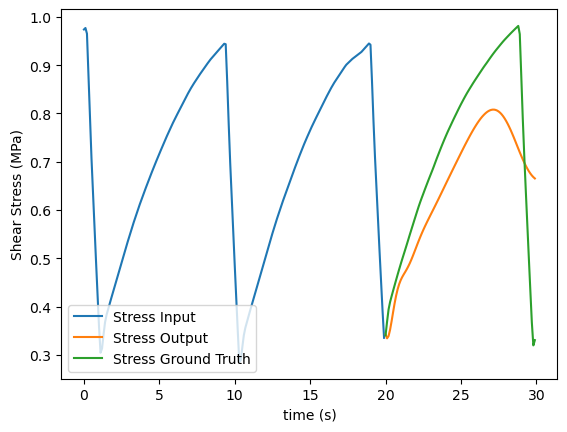

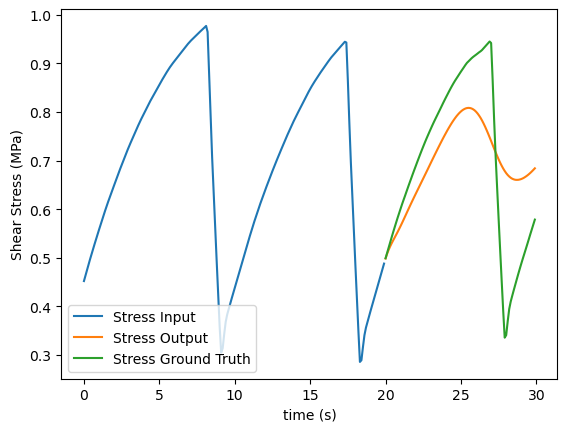

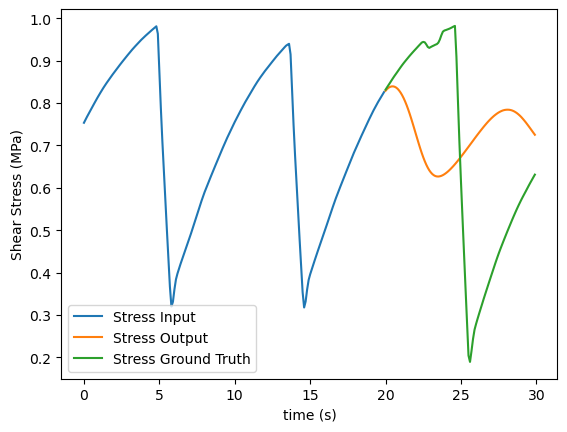

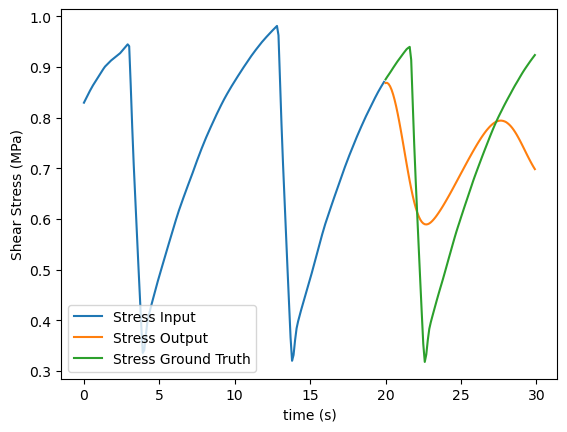

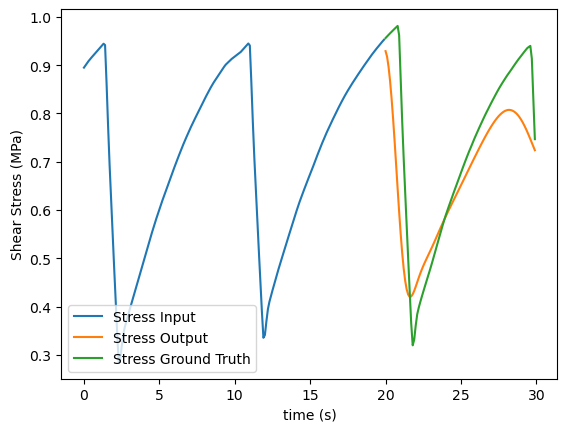

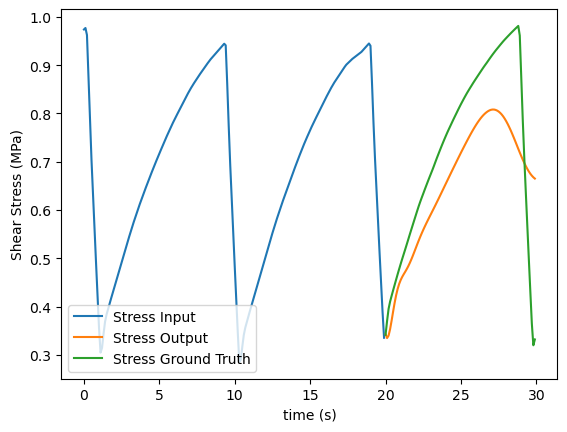

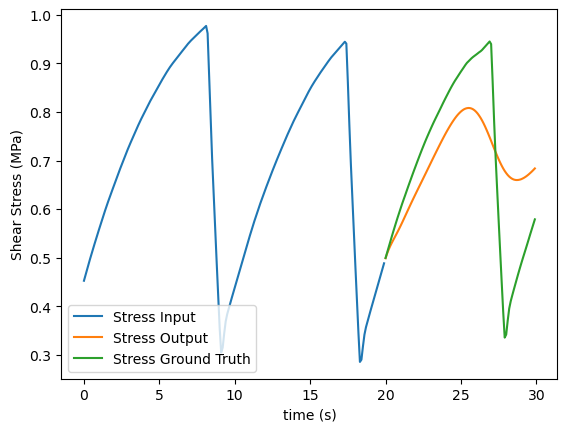

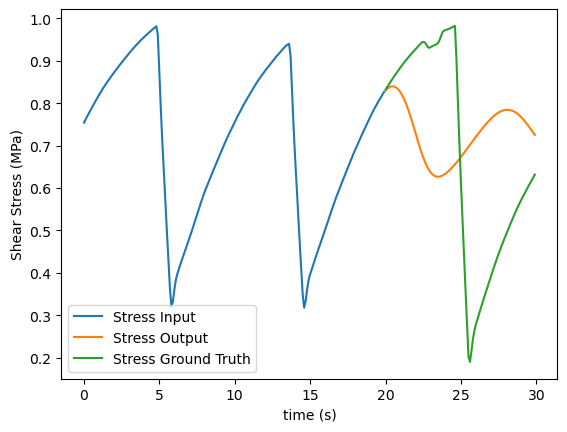

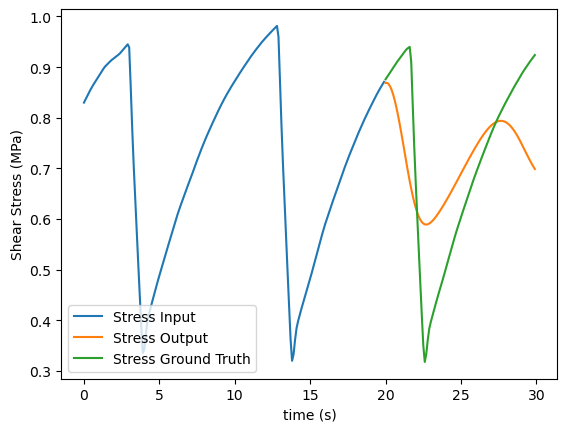

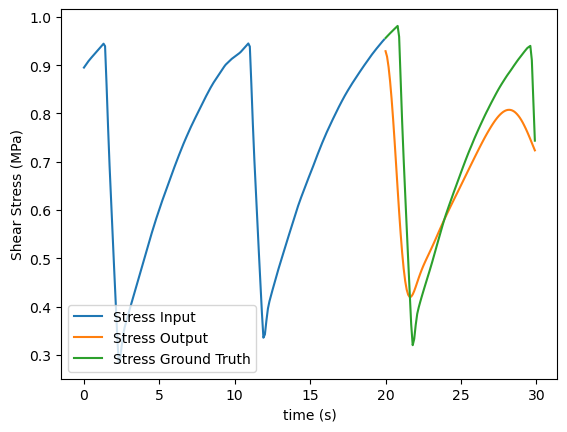

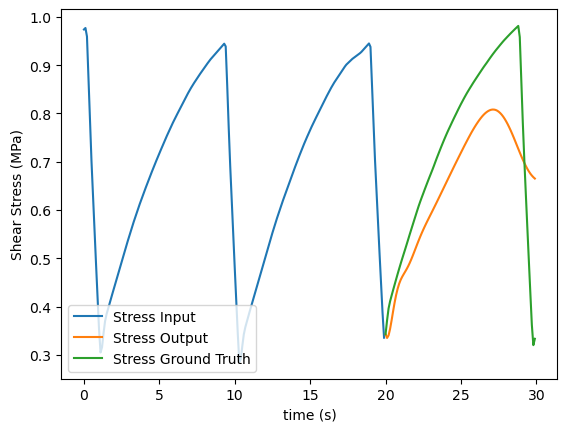

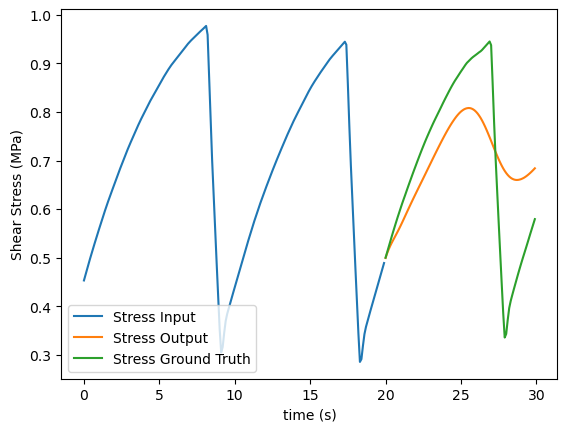

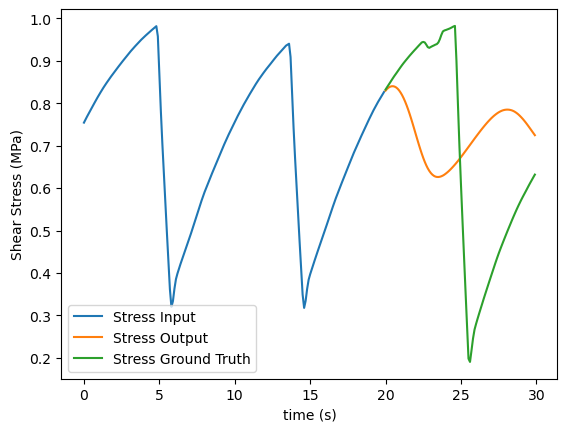

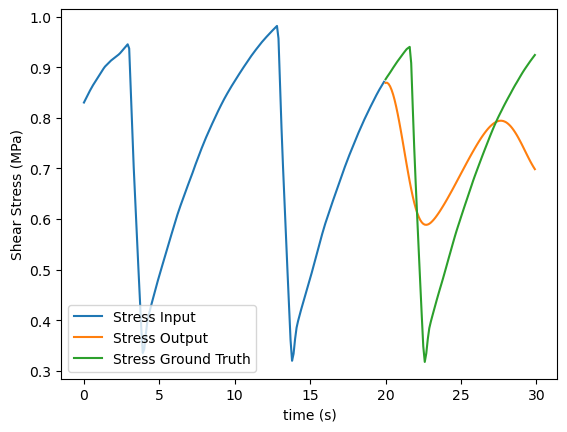

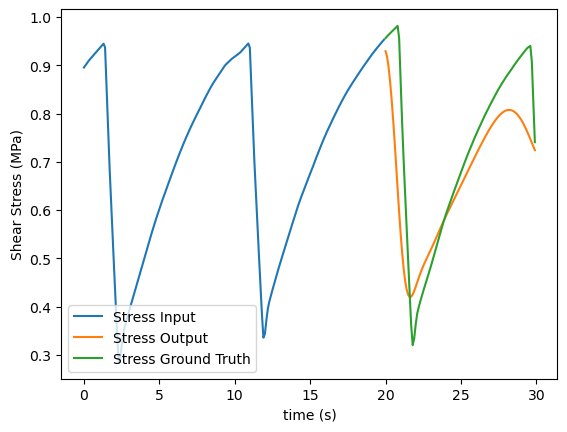

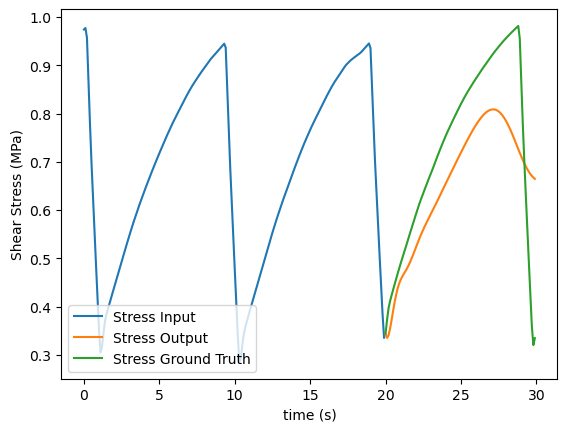

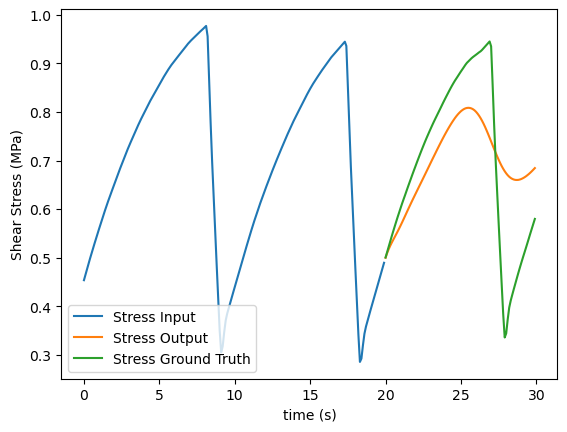

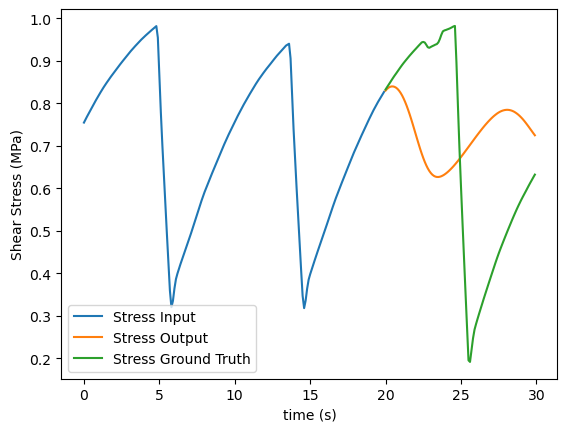

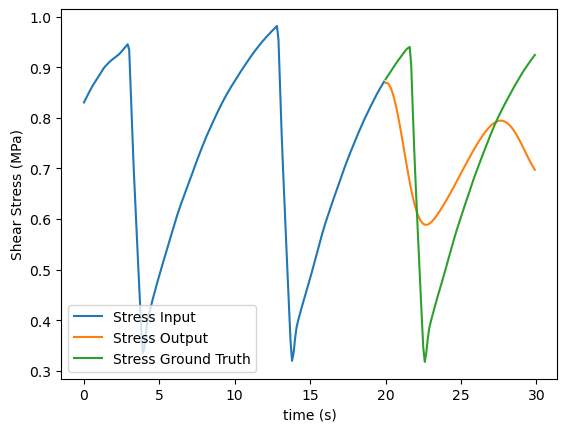

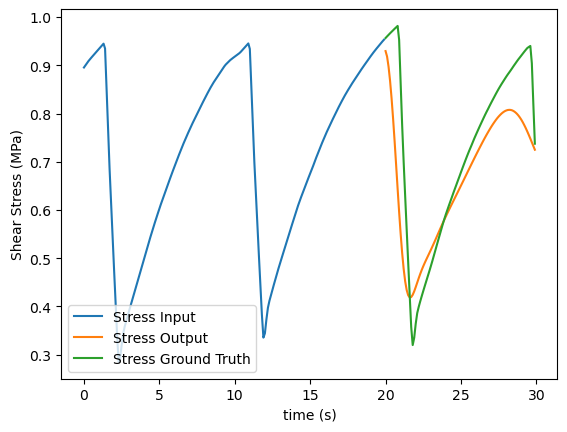

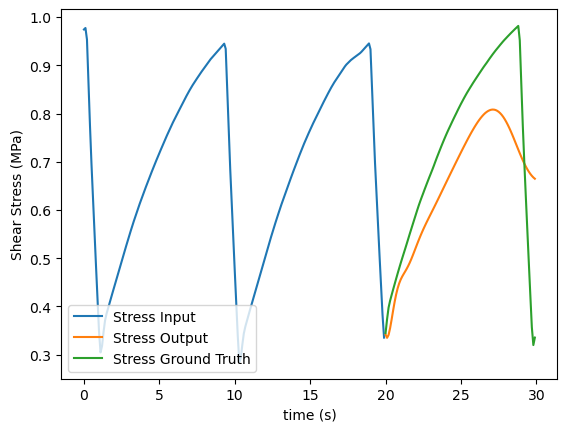

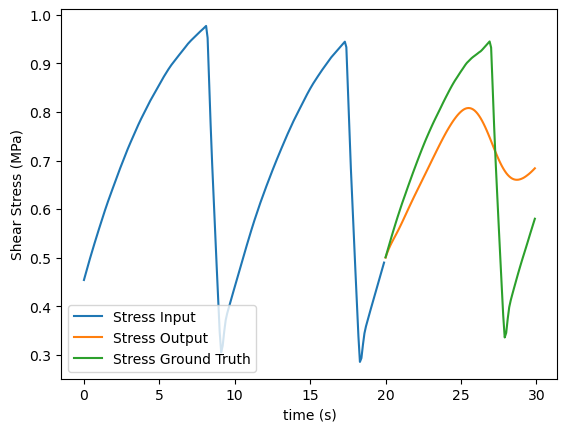

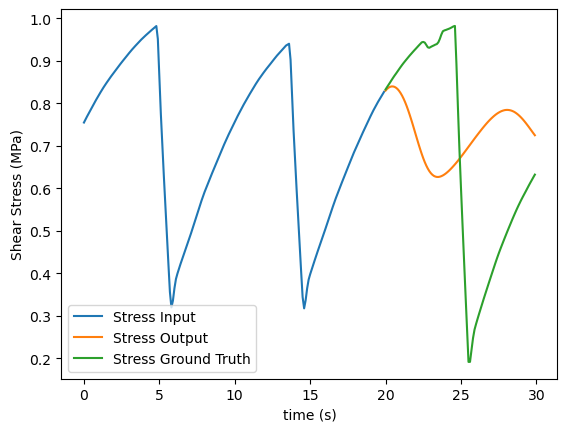

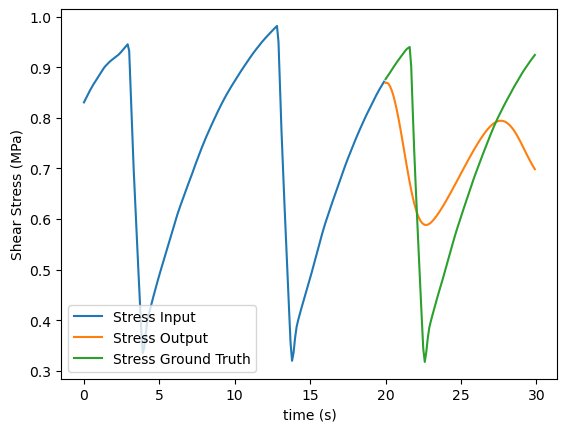

In [53]:
wndw = 20
for btch in range(1, 30):
    # img_name="p4581TRANSF_predicted_stepin_200_stepout_100_target_ShStress_window"+str(i)+".pdf"
    plt.plot(
        [r * 0.1 for r in range(0, steps_in)],
        inputte[btch][wndw].cpu(),
        label="Stress Input",
    )
    plt.plot(
        [r * 0.1 for r in range(steps_in, steps_in + steps_out)],
        outputte[btch][wndw].cpu(),
        label="Stress Output",
    )
    plt.plot(
        [r * 0.1 for r in range(steps_in, steps_in + steps_out)],
        labeltte[btch][wndw].cpu(),
        label="Stress Ground Truth",
    )
    plt.xlabel("time (s)")
    plt.ylabel("Shear Stress (MPa)")
    plt.legend(loc="lower left")
    # plt.savefig(img_name)
    plt.show()

In [54]:
r_square_avg = 0
rmse_square_avg = 0
for w in range(len(outputte)):
    for b in range(0, batch_size):
        r_square = r2_score(outputte[w][b].cpu(), labeltte[w][b].cpu())
        rmse = sqrt(
            mean_squared_error(outputte[w][b].cpu(), labeltte[w][b].cpu())
        )
        r_square_avg += r_square
        rmse_square_avg += rmse
r_square_avg = r_square_avg / (len(outputte) * batch_size)
rmse_square_avg = rmse_square_avg / (len(outputte) * batch_size)

print("r_square_avg: ", r_square_avg, " rmse_square_avg: ", rmse_square_avg)

r_square_avg:  -4.7256797426484445  rmse_square_avg:  0.16126567292945265
